In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

random_state = 42

In [2]:
cap_cols = ['Полных лет на момент поступления', 'Позиция студента в рейтинге']

def cap_data(df, cols, lower_quantile=0.05, upper_quantile=0.95):
    capped = df.copy()
    for col in cols:
        lower = capped[col].quantile(lower_quantile)
        upper = capped[col].quantile(upper_quantile)
        capped[col] = np.where(capped[col] < lower, lower, capped[col])
        capped[col] = np.where(capped[col] > upper, upper, capped[col])
    return capped

In [3]:
def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

subjects_bak_spec = read_dataset("../../../../../data/datasets/subjects_bak_spec.csv")
subjects_magistr = read_dataset("../../../../../data/datasets/subjects_magistr.csv")

subjects_bak_spec = cap_data(subjects_bak_spec, cap_cols)
subjects_magistr = cap_data(subjects_magistr, cap_cols)

In [4]:
X_s_bak_spec = subjects_bak_spec.drop(columns=["Таргет"])
y_s_bak_spec = subjects_bak_spec["Таргет"]

X_train_s_bak_spec, X_test_s_bak_spec, y_train_s_bak_spec, y_test_s_bak_spec = train_test_split(
    X_s_bak_spec,
    y_s_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_s_magistr = subjects_magistr.drop(columns=["Таргет"])
y_s_magistr = subjects_magistr["Таргет"]

X_train_s_magistr, X_test_s_magistr, y_train_s_magistr, y_test_s_magistr = train_test_split(
    X_s_magistr,
    y_s_magistr,
    test_size=0.2,
    random_state=random_state
)

import pickle

with open('../../../../../data/models/final/filtered/rf_model_s_magistr_cap_columns.pkl', 'wb') as f:
    pickle.dump(X_train_s_bak_spec.columns.tolist(), f)

Лучший порог: 0.525, F1 для класса 1: 0.744
{'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 150}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=10,
                                        min_samples_leaf=3, n_estimators=150,
                                        random_state=49))])

Отчёт классификации с оптимальным порогом:

              precision    recall  f1-score   support

           0      0.991     0.915     0.951       117
           1      0.615     0.941     0.744        17

    accuracy                          0.918       134
   macro avg      0.803     0.928     0.848       134
weighted avg      0.943     0.918     0.925       134



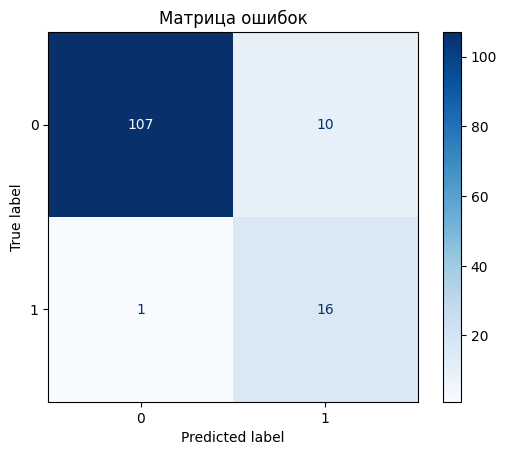

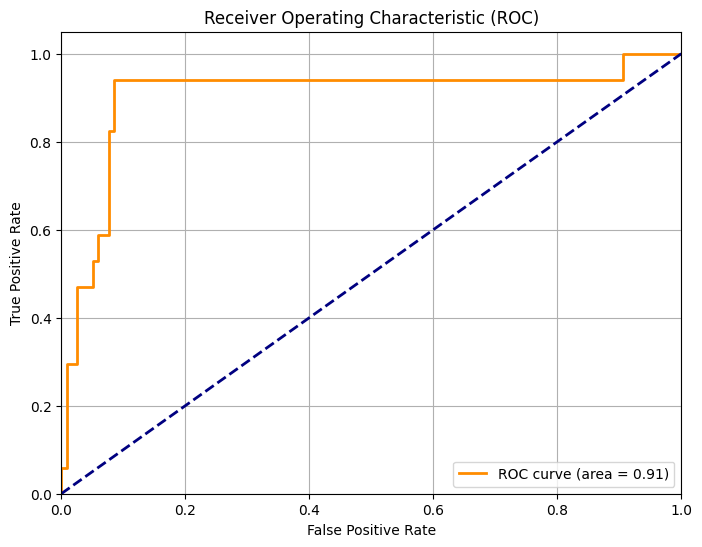

0.6474590588274738


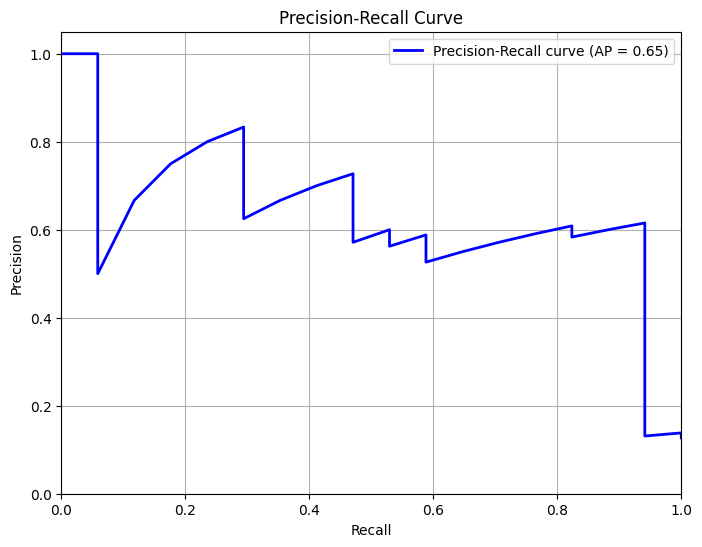

                                            feature  importance  percentage
37                      Позиция студента в рейтинге    0.367740   36.773993
9                           Общее количество долгов    0.270547   27.054716
1                            Cумма баллов испытаний    0.090606    9.060572
7                  Полных лет на момент поступления    0.059836    5.983617
11                             fromSverdlovskRegion    0.026548    2.654767
0                                         Приоритет    0.025968    2.596850
10                                 fromEkaterinburg    0.021306    2.130583
2                           Балл за инд. достижения    0.020603    2.060289
8                         Общее количество пересдач    0.018632    1.863206
3                                          Контракт    0.014571    1.457076
31                            Код направления 1: 11    0.009641    0.964097
4                             Нуждается в общежитии    0.009369    0.936850
35          

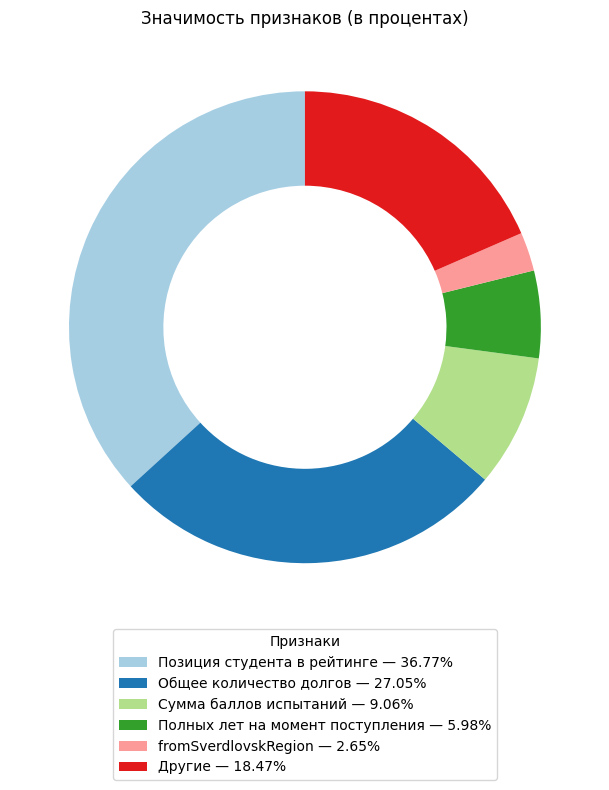

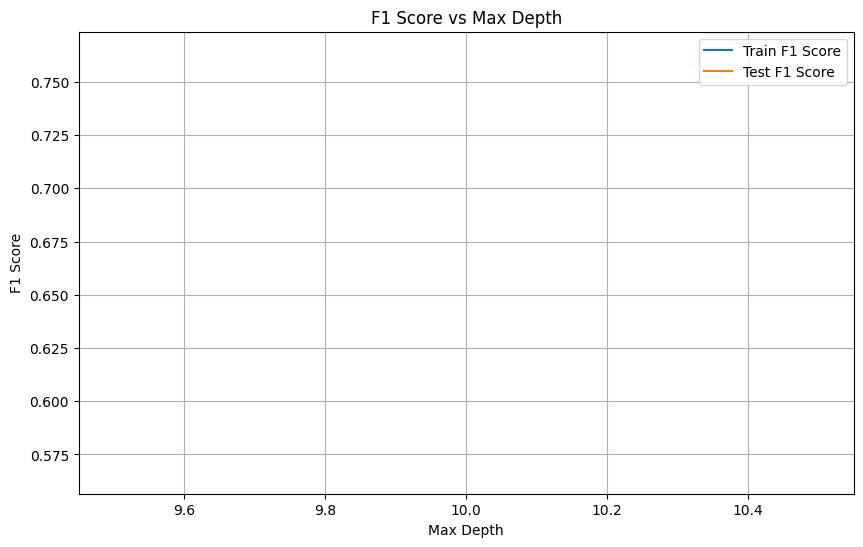

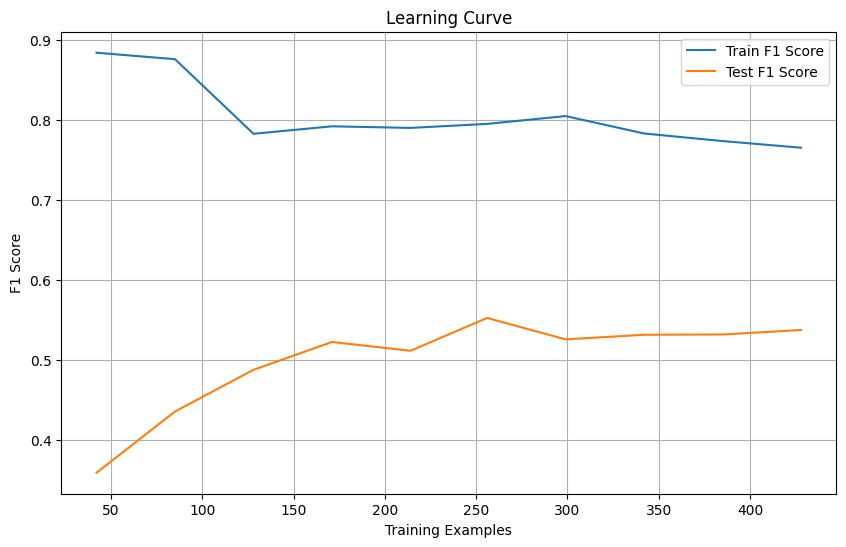

In [9]:
'''-----------------------------------------------------------------------------------------------------
                                        ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК
-----------------------------------------------------------------------------------------------------'''

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
from sklearn.metrics import make_scorer
import json
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


random_state = 49

'''-----------------------------------------------------------------------------------------------------
                                            ПОДГОТОВКА ПАЙПЛАЙНА
-----------------------------------------------------------------------------------------------------'''

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=random_state))
])

param_grid = {
    'clf__n_estimators': [150],
    'clf__criterion': ['entropy'],
    'clf__max_depth': [10],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [3],
    'clf__class_weight': ['balanced']
}

custom_scorer = make_scorer(f1_score, pos_label=1)

'''-----------------------------------------------------------------------------------------------------
                                                ОБУЧЕНИЕ МОДЕЛИ
-----------------------------------------------------------------------------------------------------'''

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train_s_magistr, y_train_s_magistr)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../../../../data/models/final/filtered/rf_model_s_magistr_cap.joblib')

'''-----------------------------------------------------------------------------------------------------
                        ПОЛУЧЕНИЕ ЛУЧШЕГО ПОРОГА И СОЗДАНИЕ ОТЧЁТА С УЧЁТОМ ЭТОГО ПОРОГА
-----------------------------------------------------------------------------------------------------'''

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    f1 = f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

with open('../../../../../data/models/final/filtered/rf_model_s_magistr_cap_config.json', 'w') as f:
    json.dump({'threshold': float(best_threshold)}, f)

print(f"Лучший порог: {best_threshold:.3f}, F1 для класса 1: {best_f1:.3f}")

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]
y_pred_s_magistr = (y_probs >= best_threshold).astype(int)

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации с оптимальным порогом:\n")
print(classification_report(y_test_s_magistr, y_pred_s_magistr, digits=3))

'''-----------------------------------------------------------------------------------------------------
                                            СОЗДАНИЕ МАТРИЦЫ ОШИБОК
-----------------------------------------------------------------------------------------------------'''

cm = confusion_matrix(y_test_s_magistr, y_pred_s_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig('rf/s_magistr/confusion_matrix_rf.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                     ВИЗУАЛИЗАЦИЯ AUC-ROC И AUC-PR
-----------------------------------------------------------------------------------------------------'''

fpr, tpr, _ = roc_curve(y_test_s_magistr, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('rf/s_magistr/roc_curve_rf_cap.png')
plt.show()

precision, recall, _ = precision_recall_curve(y_test_s_magistr, y_probs)
avg_precision = average_precision_score(y_test_s_magistr, y_probs)
print(avg_precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig('rf/s_magistr/pr_curve_rf_cap.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                          ВЫВОД ВЛИЯНИЯ ВСЕХ ПРИЗНАКОВ
-----------------------------------------------------------------------------------------------------'''

importances = best_model.named_steps['clf'].feature_importances_
feature_names = X_train_s_magistr.columns

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

total = feature_importances['importance'].sum()
feature_importances['percentage'] = (feature_importances['importance'] / total) * 100

print(feature_importances[['feature', 'importance', 'percentage']])

top_n = 5
top_features = feature_importances.head(top_n)
others_sum = feature_importances.iloc[top_n:]['importance'].sum()

if others_sum <= 0:
    others_sum = 0.0

plot_data = pd.concat([
    top_features,
    pd.DataFrame([{'feature': 'Другие', 'importance': others_sum}])
], ignore_index=True)

plot_total = plot_data['importance'].sum()
plot_data['percentage'] = (plot_data['importance'] / plot_total * 100).round(2)

plot_data.fillna(0, inplace=True)

colors = plt.cm.Paired.colors

plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(
    plot_data['importance'],
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4)
)

plt.title('Значимость признаков (в процентах)')

legend_labels = [
    f"{row['feature']} — {row['percentage']:.2f}%" for _, row in plot_data.iterrows()
]

plt.legend(wedges, legend_labels,
           title="Признаки",
           loc='upper center',
           bbox_to_anchor=(0.5, 0))

plt.tight_layout()
plt.savefig('rf/s_magistr/features_importance.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                              ВЫВОД ЗАВИСИМОСТИ F1 ОТ МАКСИМАЛЬНОЙ ГЛУБИНЫ ДЕРЕВА
-----------------------------------------------------------------------------------------------------'''

results = pd.DataFrame(grid_search.cv_results_)

results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('rf/s_magistr/f1_vs_max_depth_rf.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                           ВЫВОД КРИВОЙ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_magistr,
    y=y_train_s_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('rf/s_magistr/learning_curve_rf.png')
plt.show()

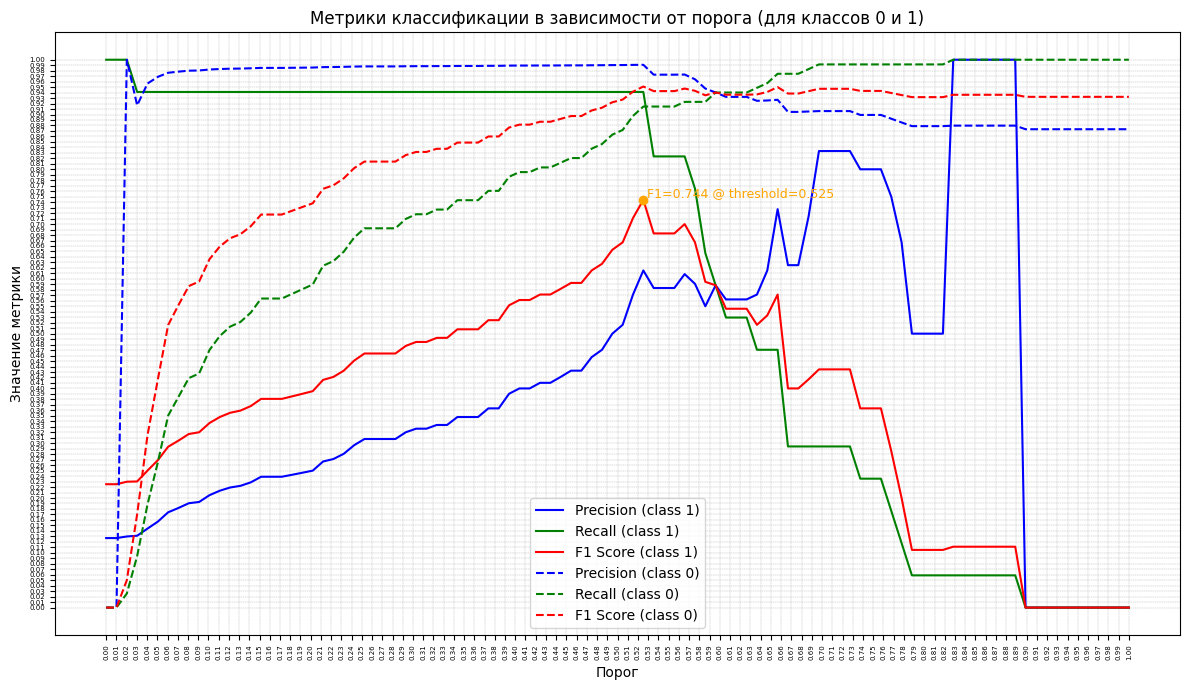

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))

max_f1_idx = np.argmax(f1_scores_1)
max_f1_value = f1_scores_1[max_f1_idx]
max_threshold = thresholds[max_f1_idx]

save_path = 'rf/s_magistr'
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.scatter(max_threshold, max_f1_value, color='orange', zorder=5)
plt.text(max_threshold, max_f1_value,
         f' F1={max_f1_value:.3f} @ threshold={max_threshold:.3f}',
         fontsize=9, color='orange', verticalalignment='bottom')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_rf.png'), dpi=300)
plt.show()

Лучший порог: 0.596, F1 для класса 1: 0.760
{'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 30, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        min_samples_leaf=2, n_estimators=50,
                                        random_state=42))])

Отчёт классификации с оптимальным порогом:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       271
           1       0.79      0.73      0.76        52

    accuracy                           0.93       323
   macro avg       0.87      0.85      0.86       323
weighted avg       0.92      0.93      0.92       323



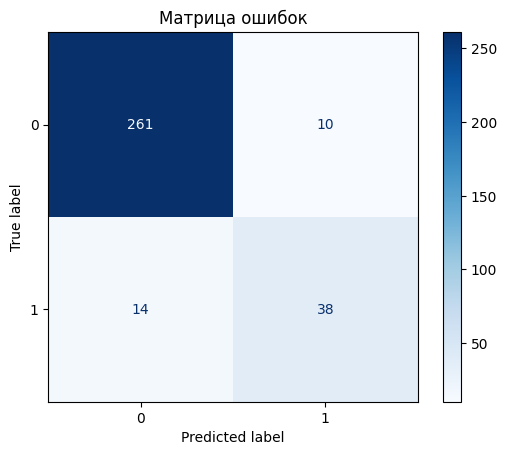

                                            feature  importance
39                      Позиция студента в рейтинге    0.318377
10                          Общее количество долгов    0.257780
1                            Cумма баллов испытаний    0.080942
8                  Полных лет на момент поступления    0.064061
3                           Балл за инд. достижения    0.038446
9                         Общее количество пересдач    0.019561
0                                         Приоритет    0.017803
13                          Human Development Index    0.017205
33                            Код направления 1: 11    0.016686
21                                       Специалист    0.016627
4                                          Контракт    0.016527
11                                 fromEkaterinburg    0.012983
24                                 Профильная Школа    0.011719
37                             Код направления 3: 3    0.010822
38                             Код напра

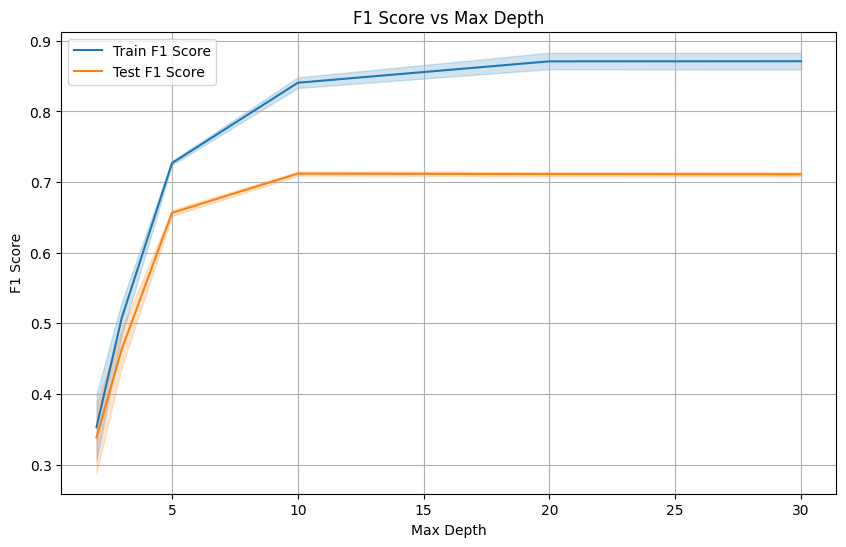

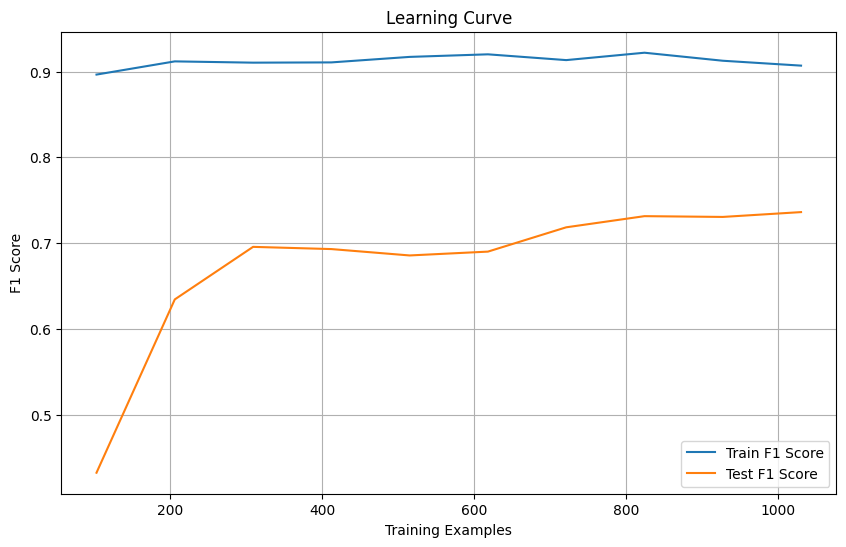

In [18]:
'''-----------------------------------------------------------------------------------------------------
                                        ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК
-----------------------------------------------------------------------------------------------------'''

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
from sklearn.metrics import make_scorer

random_state = 42

'''-----------------------------------------------------------------------------------------------------
                                            ПОДГОТОВКА ПАЙПЛАЙНА
-----------------------------------------------------------------------------------------------------'''

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=random_state))
])

param_grid = {
    'clf__n_estimators': [50, 100, 150],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [2, 3, 5, 10, 20, 30, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': [None, 'balanced']
}

custom_scorer = make_scorer(f1_score, pos_label=1)

'''-----------------------------------------------------------------------------------------------------
                                                ОБУЧЕНИЕ МОДЕЛИ
-----------------------------------------------------------------------------------------------------'''

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train_s_bak_spec, y_train_s_bak_spec)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../../../../data/models/final/filtered/rf_model_s_bak_spec_cap.joblib')

'''-----------------------------------------------------------------------------------------------------
                        ПОЛУЧЕНИЕ ЛУЧШЕГО ПОРОГА И СОЗДАНИЕ ОТЧЁТА С УЧЁТОМ ЭТОГО ПОРОГА
-----------------------------------------------------------------------------------------------------'''

y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    f1 = f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Лучший порог: {best_threshold:.3f}, F1 для класса 1: {best_f1:.3f}")

y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]
y_pred_s_bak_spec = (y_probs >= best_threshold).astype(int)

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации с оптимальным порогом:\n")
print(classification_report(y_test_s_bak_spec, y_pred_s_bak_spec))

'''-----------------------------------------------------------------------------------------------------
                                            СОЗДАНИЕ МАТРИЦЫ ОШИБОК
-----------------------------------------------------------------------------------------------------'''

cm = confusion_matrix(y_test_s_bak_spec, y_pred_s_bak_spec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig('rf/s_bak_spec/confusion_matrix_rf.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                          ВЫВОД ВЛИЯНИЯ ВСЕХ ПРИЗНАКОВ
-----------------------------------------------------------------------------------------------------'''

importances = best_model.named_steps['clf'].feature_importances_
feature_importances = pd.DataFrame({
    'feature': X_train_s_bak_spec.columns,
    'importance': importances
}).sort_values('importance', ascending=False)
print(feature_importances)

'''-----------------------------------------------------------------------------------------------------
                              ВЫВОД ЗАВИСИМОСТИ F1 ОТ МАКСИМАЛЬНОЙ ГЛУБИНЫ ДЕРЕВА
-----------------------------------------------------------------------------------------------------'''

results = pd.DataFrame(grid_search.cv_results_)

results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('rf/s_bak_spec/f1_vs_max_depth_rf.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                           ВЫВОД КРИВОЙ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_bak_spec,
    y=y_train_s_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('rf/s_bak_spec/learning_curve_rf.png')
plt.show()

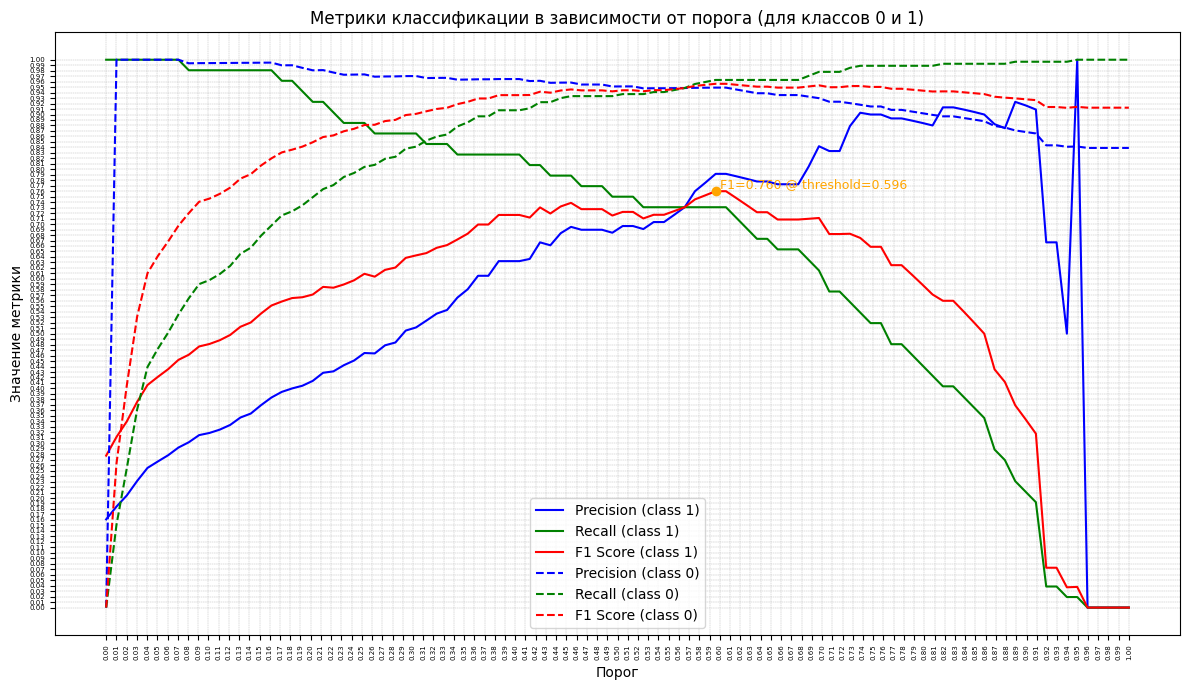

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

max_f1_idx = np.argmax(f1_scores_1)
max_f1_value = f1_scores_1[max_f1_idx]
max_threshold = thresholds[max_f1_idx]

save_path = 'rf/s_bak_spec'
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.scatter(max_threshold, max_f1_value, color='orange', zorder=5)
plt.text(max_threshold, max_f1_value,
         f' F1={max_f1_value:.3f} @ threshold={max_threshold:.3f}',
         fontsize=9, color='orange', verticalalignment='bottom')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_rf.png'), dpi=300)
plt.show()